### do gen-matching with delphes root files

In [45]:
#env : Lpr

In [46]:
import uproot
import awkward as ak
from glob import glob
from coffea.nanoevents import NanoEventsFactory, DelphesSchema, BaseSchema
import pickle, json, gzip
import numpy as np
from typing import Optional, List, Dict, Tuple
from copy import copy
from matplotlib import colors
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler
from tqdm import tqdm
import pathlib
import os
import boost_histogram as bh

In [47]:
plot_dir = "../plots/tagger/29Sep2024"
_ = os.system(f"mkdir -p {plot_dir}")

In [48]:
import custom
print("Loaded CustomDelphesSchema:", custom.CustomDelphesSchema)


Loaded CustomDelphesSchema: <class 'custom.CustomDelphesSchema'>


In [49]:
delphes_roots = {
    'TTbar_semilep' : "/data/bond/zhaoyz/Pheno/ntuplizer/output_with_PUPPI/TTbar_semilep_part1_25M/ntuple_events_delphes_356.root",
}
   
files = {typefile : {} for typefile in delphes_roots}
for typefile in delphes_roots:
    files[typefile] = NanoEventsFactory.from_root(
        delphes_roots[typefile],
        treepath="/tree",
        schemaclass=custom.CustomDelphesSchema,
    ).events()

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch JetPUPPI_size in <TTree 'tree' (9214 branches) at 0x7f6278946e80>, taking first instance
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch Particle_size in <TTree 'tree' (9214 branches) at 0x7f6278946e80>, taking first instance
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch JetPUPPIAK8_size in <TTree 'tree' (9214 branches) at 0x7f6278946e80>, taking first instance
  warnings.warn(
/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch Electron_size in <TTree 'tree' (9214 branches) at 0x7f6278946e80>, taking first instance
  warnings.warn(
/home/pku/zha

In [50]:
### find the score label index
labels = [
    #  H->2 prong
    "H_bb", "H_cc", "H_ss", "H_qq", "H_bc", "H_cs", "H_bq", "H_cq", "H_sq", "H_gg", "H_ee", "H_mm", "H_tauhtaue", "H_tauhtaum", "H_tauhtauh", 

    #  H->4/3 prong
    "H_AA_bbbb", "H_AA_bbcc", "H_AA_bbss", "H_AA_bbqq", "H_AA_bbgg", "H_AA_bbee", "H_AA_bbmm",
    "H_AA_bbtauhtaue", "H_AA_bbtauhtaum", "H_AA_bbtauhtauh",

    "H_AA_bbb", "H_AA_bbc", "H_AA_bbs", "H_AA_bbq", "H_AA_bbg", "H_AA_bbe", "H_AA_bbm",

    "H_AA_cccc", "H_AA_ccss", "H_AA_ccqq", "H_AA_ccgg", "H_AA_ccee", "H_AA_ccmm",
    "H_AA_cctauhtaue", "H_AA_cctauhtaum", "H_AA_cctauhtauh",

    "H_AA_ccb", "H_AA_ccc", "H_AA_ccs", "H_AA_ccq", "H_AA_ccg", "H_AA_cce", "H_AA_ccm",

    "H_AA_ssss", "H_AA_ssqq", "H_AA_ssgg", "H_AA_ssee", "H_AA_ssmm",
    "H_AA_sstauhtaue", "H_AA_sstauhtaum", "H_AA_sstauhtauh",

    "H_AA_ssb", "H_AA_ssc", "H_AA_sss", "H_AA_ssq", "H_AA_ssg", "H_AA_sse", "H_AA_ssm",

    "H_AA_qqqq", "H_AA_qqgg", "H_AA_qqee", "H_AA_qqmm",
    "H_AA_qqtauhtaue", "H_AA_qqtauhtaum", "H_AA_qqtauhtauh",

    "H_AA_qqb", "H_AA_qqc", "H_AA_qqs", "H_AA_qqq", "H_AA_qqg", "H_AA_qqe", "H_AA_qqm",

    "H_AA_gggg", "H_AA_ggee", "H_AA_ggmm",
    "H_AA_ggtauhtaue", "H_AA_ggtauhtaum", "H_AA_ggtauhtauh",

    "H_AA_ggb", "H_AA_ggc", "H_AA_ggs", "H_AA_ggq", "H_AA_ggg", "H_AA_gge", "H_AA_ggm",

    "H_AA_bee", "H_AA_cee", "H_AA_see", "H_AA_qee", "H_AA_gee",
    "H_AA_bmm", "H_AA_cmm", "H_AA_smm", "H_AA_qmm", "H_AA_gmm",

    "H_AA_btauhtaue", "H_AA_ctauhtaue", "H_AA_stauhtaue", "H_AA_qtauhtaue", "H_AA_gtauhtaue",
    "H_AA_btauhtaum", "H_AA_ctauhtaum", "H_AA_stauhtaum", "H_AA_qtauhtaum", "H_AA_gtauhtaum",
    "H_AA_btauhtauh", "H_AA_ctauhtauh", "H_AA_stauhtauh", "H_AA_qtauhtauh", "H_AA_gtauhtauh",

    #  (H+H-: H_AA_bbcs, H_AA_bbsq, H_AA_ssbc, H_AA_ssbq not available)
    "H_AA_qqqb", "H_AA_qqqc", "H_AA_qqqs",
    "H_AA_bbcq",
    "H_AA_ccbs", "H_AA_ccbq", "H_AA_ccsq",
    "H_AA_sscq",
    "H_AA_qqbc", "H_AA_qqbs", "H_AA_qqcs",
    "H_AA_bcsq",

    "H_AA_bcs", "H_AA_bcq", "H_AA_bsq", "H_AA_csq", 

    "H_AA_bcev", "H_AA_csev", "H_AA_bqev", "H_AA_cqev", "H_AA_sqev", "H_AA_qqev",
    "H_AA_bcmv", "H_AA_csmv", "H_AA_bqmv", "H_AA_cqmv", "H_AA_sqmv", "H_AA_qqmv",
    "H_AA_bctauev", "H_AA_cstauev", "H_AA_bqtauev", "H_AA_cqtauev", "H_AA_sqtauev", "H_AA_qqtauev",
    "H_AA_bctaumv", "H_AA_cstaumv", "H_AA_bqtaumv", "H_AA_cqtaumv", "H_AA_sqtaumv", "H_AA_qqtaumv",
    "H_AA_bctauhv", "H_AA_cstauhv", "H_AA_bqtauhv", "H_AA_cqtauhv", "H_AA_sqtauhv", "H_AA_qqtauhv",


    "QCD_bbccss", "QCD_bbccs", "QCD_bbcc", "QCD_bbcss", "QCD_bbcs", "QCD_bbc", "QCD_bbss", "QCD_bbs", "QCD_bb",
    "QCD_bccss", "QCD_bccs", "QCD_bcc", "QCD_bcss", "QCD_bcs", "QCD_bc", "QCD_bss", "QCD_bs", "QCD_b",
    "QCD_ccss", "QCD_ccs", "QCD_cc", "QCD_css", "QCD_cs", "QCD_c", "QCD_ss", "QCD_s", "QCD_light",

]

index_hbc = labels.index("H_bc")
index_hbq = labels.index("H_bq")
index_hbb = labels.index("H_bb")
index_hcc = labels.index("H_cc")
index_qcd_start = labels.index("QCD_bbccss")

In [51]:
import math
def delta_r(a, b):
    deta = a.Eta - b.Eta
    dphi = (a.Phi - b.Phi + math.pi) % (2 * math.pi) - math.pi
    return np.hypot(deta, dphi)

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.ROOT)

def flow(hist: bh.Histogram, overflow: bool=False, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

skim_vars = {
    "eta": "Eta",
    "phi": "Phi",
    "mass": "Mass",
    "pt": "Pt",
}

### Investigate jet information

In [52]:
events = files["TTbar_semilep"]


#### let's see the #AK8 jets distribution

In [53]:
# initially we only test leading JetPUPPIAK8 jet(as candidate fatjet) matching situations
# anyway, we will use one AK8 jets in the end
# now, we use the 
# num_jets = 1
# candidate_fatjets = ak.flatten(ak.pad_none(events.JetPUPPIAK8, num_jets, axis=1)[:, :num_jets], axis = 1)

In [54]:
def get_hbcvsqcd(df):
    df["hbc"] = df[f"jet_probs_{str(index_hbc)}"]
    df["qcd"] = ak.zeros_like(df["hbc"])
    for idx in range(index_qcd_start,188):
        df["qcd"] = df["qcd"] + df[f"jet_probs_{str(idx)}"]
    df["hbcvsqcd"] = df["hbc"]/(df["hbc"] + df["qcd"])



### We will always use Hbc tagger to order the jet

In [55]:
#compute tagger score
leading_tagger = np.max(events[f"jet_probs_{str(index_hbc)}"],axis = 1) #leading tagger score
leading_tagger_indices = (events[f"jet_probs_{str(index_hbc)}"] == leading_tagger)

#order other object
get_hbcvsqcd(events)
leading_hbc = events[f"jet_probs_{str(index_hbc)}"][leading_tagger_indices][:,0]
leading_hbcvsqcd = events["hbcvsqcd"][leading_tagger_indices][:,0]
leading_qcd = events["qcd"][leading_tagger_indices][:,0]
leading_hbq = events[f"jet_probs_{str(index_hbq)}"][leading_tagger_indices][:,0]
#currently top not available

#candidate jet is the jet with leading Hbc tagger
leading_fatjet = events.JetPUPPIAK8[leading_tagger_indices][:,0]
candidate_fatjets = leading_fatjet

In [56]:
# how to compute soft-drop mass
candidate_fatjets.SoftDroppedP4_5[...,0].mass

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


<Array [89.5, 12.9, 88.2, ... 5.87, 0.106, 144] type='1270 * ?float64'>

### jet matching

In [57]:
d_PDGID = 1
u_PDGID = 2
s_PDGID = 3
b_PDGID = 5
c_PDGID = 4
TOP_PDGID = 6

g_PDGID = 21

ELE_PDGID = 11
vELE_PDGID = 12
MU_PDGID = 13
vMU_PDGID = 14
TAU_PDGID = 15
vTAU_PDGID = 16

Z_PDGID = 23
W_PDGID = 24
H_PDGID = 25

#define deltaR
deltaR = 0.8

In [58]:
# finding the two gen tops

tops = events.Particle[
    (abs(events.Particle.PID) == TOP_PDGID) * (events.Particle.Status == 62)
]

In [59]:
# collect all bs, including the leptonic b and hadronic b
bs = events.Particle[tops.D2]

In [60]:
# find the last W index

def find_last_position(arr, value):
    mask = (arr == value)
    reversed_mask = mask[:, ::-1]
    reversed_positions = ak.argmax(reversed_mask, axis=1)
    lengths = ak.num(arr, axis=1)
    positions = lengths - 1 - reversed_positions
    return positions



In [61]:
pos_w_plus = find_last_position(events.Particle.PID, 24)
pos_w_plus

<Array [664, 1033, 746, 662, ... 587, 272, 523] type='1270 * ?int64'>

In [62]:
pos_w_minus = find_last_position(events.Particle.PID, -24)
pos_w_minus

<Array [665, 1026, 754, 633, ... 583, 292, 516] type='1270 * ?int64'>

In [63]:
#last copy W position
w_index_array = ak.Array(ak.Array([pos_w_plus, pos_w_minus]).to_numpy().T)

In [64]:
# collect last copy W
ws = events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, w_index_array.to_numpy()]

In [65]:
# define hadronic decay W
had_w_sel = (abs(events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, ws.D1.to_numpy()].PID) <= 5)

In [66]:
# define leptonic decay W
lep_w_sel = (abs(events.Particle[ak.Array([range(len(events.Particle))]).to_numpy().T, ws.D1.to_numpy()].PID) > 6)

In [67]:
# collect all hadronic decay W in all events
had_ws = ws[had_w_sel]
lep_ws = ws[lep_w_sel]

In [68]:
# collect hadronic W's daughter
had_ws_D1 = ak.flatten(events.Particle[ak.singletons(had_ws.D1)], axis = 1)
had_ws_D2 = ak.flatten(events.Particle[ak.singletons(had_ws.D2)], axis = 1)

In [69]:
had_ws_D1_match = (delta_r(had_ws_D1,candidate_fatjets) < deltaR)
had_ws_D2_match = (delta_r(had_ws_D2,candidate_fatjets) < deltaR)

In [70]:
# W decay tag
wcd = (( abs(had_ws_D1.PID) == 1) & (abs(had_ws_D2.PID) == 4 )) | (( abs(had_ws_D1.PID) == 4) & (abs(had_ws_D2.PID) == 1 ))
wcs = (( abs(had_ws_D1.PID) == 3) & (abs(had_ws_D2.PID) == 4 )) | (( abs(had_ws_D1.PID) == 4) & (abs(had_ws_D2.PID) == 3 ))
wcb = (( abs(had_ws_D1.PID) == 5) & (abs(had_ws_D2.PID) == 4 )) | (( abs(had_ws_D1.PID) == 4) & (abs(had_ws_D2.PID) == 5 ))

wud = (( abs(had_ws_D1.PID) == 2) & (abs(had_ws_D2.PID) == 1 )) | (( abs(had_ws_D1.PID) == 1) & (abs(had_ws_D2.PID) == 2 ))
wub = (( abs(had_ws_D1.PID) == 2) & (abs(had_ws_D2.PID) == 5 )) | (( abs(had_ws_D1.PID) == 5) & (abs(had_ws_D2.PID) == 2 ))
wus = (( abs(had_ws_D1.PID) == 2) & (abs(had_ws_D2.PID) == 3 )) | (( abs(had_ws_D1.PID) == 3) & (abs(had_ws_D2.PID) == 2 ))

In [71]:
# collect hadronic decay tops' b(the same sign with hadronic W)
bs_had = ak.flatten(ak.pad_none(bs[had_ws.Charge == abs(bs.PID)/bs.PID ], 1, axis = 1, clip = True), axis = 1)

In [72]:
# collect leptonic decay tops' b(the same sign with leptonic W)
bs_lep = ak.flatten(ak.pad_none(bs[lep_ws.Charge == abs(bs.PID)/bs.PID ], 1, axis = 1, clip = True), axis = 1)

In [73]:
had_b_jet_match = (delta_r(bs_had,candidate_fatjets) <= deltaR)
lep_b_jet_match = (delta_r(bs_lep,candidate_fatjets) <= deltaR)

In [74]:
match_dict = {
    "top_matched(t->bqq)": had_ws_D1_match * had_ws_D2_match * had_b_jet_match * ~lep_b_jet_match,
    "top_matched(t->bq)": (had_ws_D1_match * ~had_ws_D2_match * had_b_jet_match * ~lep_b_jet_match) | (~had_ws_D1_match * had_ws_D2_match * had_b_jet_match * ~lep_b_jet_match),
    
    "lep.b + W_matched" : had_ws_D1_match * had_ws_D2_match * ~had_b_jet_match * lep_b_jet_match,
    "lep.b + q_matched" : (had_ws_D1_match * ~had_ws_D2_match * ~had_b_jet_match * lep_b_jet_match) | (~had_ws_D1_match * had_ws_D2_match * ~had_b_jet_match * lep_b_jet_match),
    
    "W_matched(W->cd)": ~lep_b_jet_match * ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wcd,
    "W_matched(W->cs)": ~lep_b_jet_match * ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wcs,
    "W_matched(W->cb)": ~lep_b_jet_match * ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wcb,
    "W_matched(W->ud)": ~lep_b_jet_match * ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wud,
    "W_matched(W->ub)": ~lep_b_jet_match * ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wub,
    "W_matched(W->us)": ~lep_b_jet_match * ~had_b_jet_match * had_ws_D1_match * had_ws_D2_match * wus,
    
    "b_matched(had.t)" : ~had_ws_D1_match * ~had_ws_D2_match * had_b_jet_match * ~lep_b_jet_match,
    "b_matched(lep.t)" : ~had_ws_D1_match * ~had_ws_D2_match * ~had_b_jet_match * lep_b_jet_match,
    
    "bb_matched"       : ~had_ws_D1_match * ~had_ws_D2_match * had_b_jet_match * lep_b_jet_match,
    "bb + q_matched"       : (~had_ws_D1_match * had_ws_D2_match * had_b_jet_match * lep_b_jet_match) | (had_ws_D1_match * ~had_ws_D2_match * had_b_jet_match * lep_b_jet_match),
    "bb + W_matched"       : had_ws_D1_match * had_ws_D2_match * had_b_jet_match * lep_b_jet_match,
    
    "q_matched(had.W)" : (~had_ws_D1_match * had_ws_D2_match * ~had_b_jet_match * ~lep_b_jet_match) | (had_ws_D1_match * ~had_ws_D2_match * ~had_b_jet_match * ~lep_b_jet_match),
    
    "unmatched" : ~had_ws_D1_match * ~had_ws_D2_match * ~had_b_jet_match * ~lep_b_jet_match,
}

In [75]:
len(match_dict["unmatched"])

1270

In [76]:
np.sum(match_dict["unmatched"])

291

In [77]:
np.sum(match_dict["top_matched(t->bq)"])

292

In [78]:
len_n = 0
for match in match_dict:
    len_n += np.sum(np.sum(match_dict[match]))
print(len_n)

1270


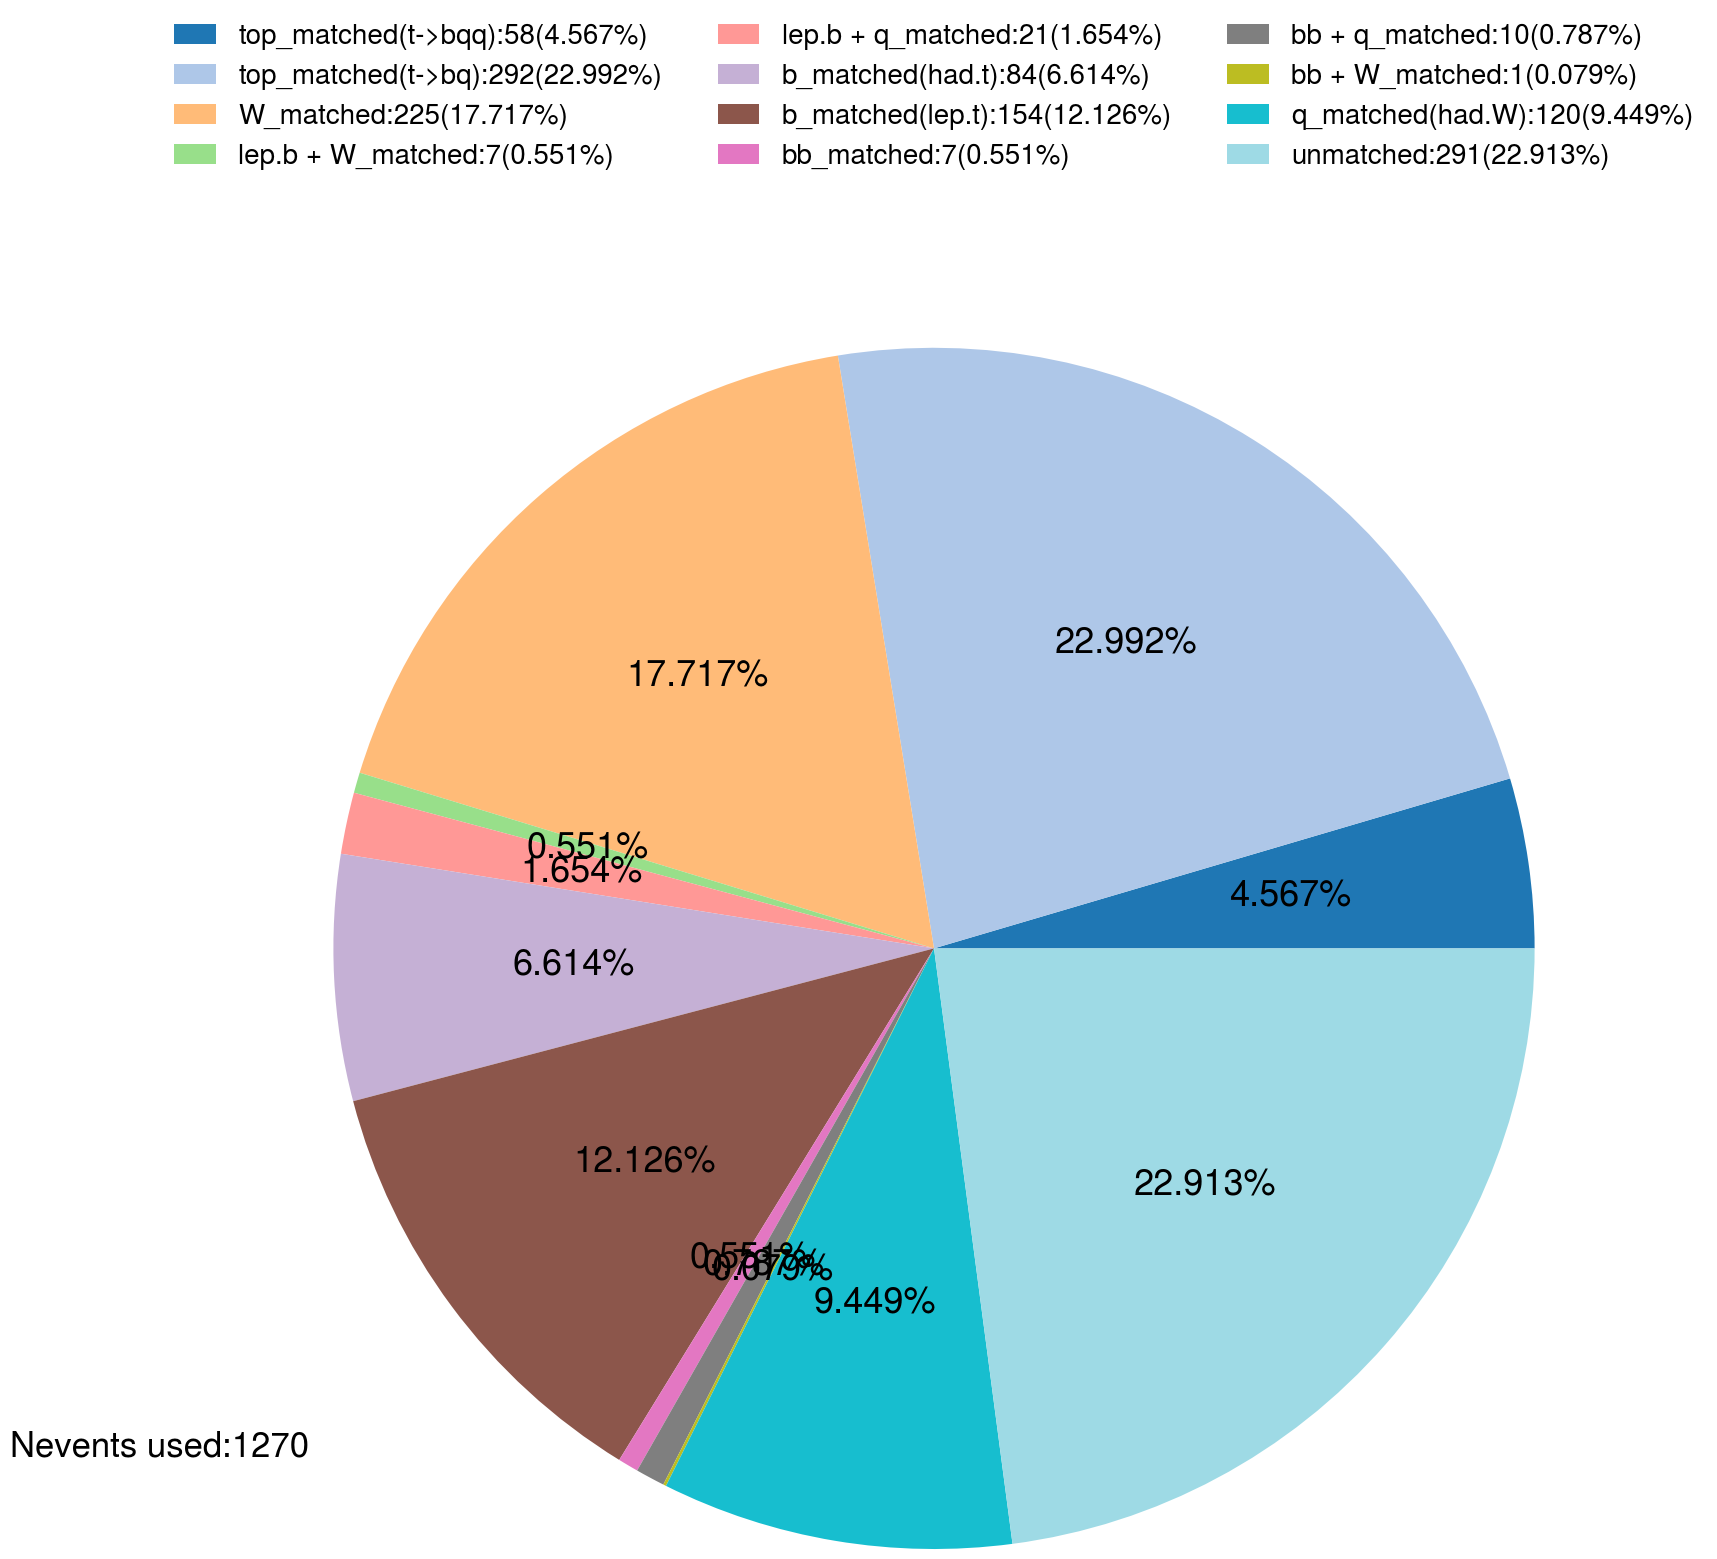

In [79]:
# make a pie-chart to visulize the fraction
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

plt.figure(figsize=(15,15))
ax=plt.gca()
plt.grid()

colors = plt.cm.tab20(np.linspace(0, 1, 12))

W_matched_num = 0
for match_type in match_dict:
    if match_type.startswith("W_matched"):
        W_matched_num += np.sum(match_dict[match_type])

labels = ['top_matched(t->bqq)', 'top_matched(t->bq)', 'W_matched', "lep.b + W_matched", "lep.b + q_matched" ,"b_matched(had.t)", "b_matched(lep.t)","bb_matched","bb + q_matched","bb + W_matched", "q_matched(had.W)",'unmatched']

sizes = []
len_n = len(match_dict["unmatched"])
labels_with_num = []
for label in labels:
    if not label.startswith("W_matched"):
        size_to_add = np.sum(match_dict[label])
        sizes.append(size_to_add)
        labels_with_num.append(label + ":"  + str(np.sum(match_dict[label])) + "(" + str(round(np.sum(match_dict[label])*100/len_n,3)) + "%)")
    else:
        size_to_add = W_matched_num
        sizes.append(size_to_add)
        labels_with_num.append(label + ":"  + str(size_to_add) + "(" + str(round(size_to_add*100/len_n,3)) + "%)")
# colors = ['#ffff00', '#2ca02c', '#ff7f0e', '#800080','red']
# highlight some component(optional)
explode = (0., 0, 0, 0, 0, 0,0,0,0,0, 0,0)
# plot the pie chat
plt.pie(sizes, labels=None, autopct='%1.3f%%', startangle=0, explode=explode, radius=1.3, colors = colors)
plt.legend(labels_with_num, loc='lower center',fontsize = 20, ncol =3, bbox_to_anchor=(0.5, 1.15))
# set title
# plt.title(r'$\ \ Signal' + "" + r'\ jet_{a}\ decomposition $',fontsize = 30)
# plt.title("ttbar(semi-lep) samples Wcb candidate jet decomposition", fontsize = 25)
# title_text = 'Pie Chart Example'

plt.text(-2,-1.1, f"Nevents used:{str(len_n)}", fontsize=25)
plt.savefig(f"{plot_dir}/Piechart_"+ "wcb" + "_deco.pdf", bbox_inches='tight')
plt.show()

In [80]:
labels = ['top_matched(t->bqq)', 'top_matched(t->bq)', 'W_matched', "lep.b + W_matched", "lep.b + q_matched" ,"b_matched(had.t)", "b_matched(lep.t)","bb_matched","bb + q_matched","bb + W_matched", "q_matched(had.W)",'unmatched']
print(len(labels))

12


### start to compute N(b-tag)

In [81]:
files["TTbar_semilep"]["JetPUPPI"]

<NanoCollectionArray [[{fUniqueID: 0, ... ] type='1270 * var * struct[["fUniqueI...'>

In [82]:
files["TTbar_semilep"]["JetPUPPI"]["Flavor"][2] == b_PDGID 

<Array [True, True, False, False] type='4 * bool'>

In [83]:
# this should actually be used to define b-tag
np.sum(files["TTbar_semilep"]["JetPUPPI"]["Flavor"][2] == b_PDGID)

2

In [84]:
files["TTbar_semilep"]["JetPUPPI"][2] #a event has N jets

<NanoCollectionArray [{fUniqueID: 0, fBits: 50331648, ... ] type='4 * struct[["f...'>

In [85]:
# this should not be used
# files["TTbar_semilep"]["Jet"].BTag[2] #see how many jets are matched to b quark

### now find n_b_jet

In [86]:
def find_closest_SF_awkward(json_path, arr):
    with open(json_path, 'r') as json_file:
        json_SF = json.load(json_file)

    # 提取 pT 和 SF 的值
    pT_values = np.array([item['pT'] for item in json_SF])
    SF_values = np.array([item['SF'] for item in json_SF])
    
    # 创建存放结果的awkward数组
    SF_result = []

    for subarr in arr:
        sub_result = []
        for pT_i in subarr:
            # 查找最接近的 pT 值的索引
            idx = (np.abs(pT_values - pT_i)).argmin()
            # 获取对应的 SF 值
            sub_result.append(SF_values[idx])
        SF_result.append(sub_result)
    
    return ak.Array(SF_result)

In [87]:
pT_distribution = events["JetPUPPI"].PT

In [88]:
mis_tag_udsg = {
    "Tight" : 0.001,
    "Medium": 0.01,
    "Loose" : 0.1,
    "Ideal" : 0,
}

mis_tag_c = {
    "Tight" : 0.04,
    "Medium": 0.13,
    "Loose" : 0.3,
    "Ideal" : 0,
}

In [89]:
# efficiency
json_dir = "./json/28Aug24"
b_tag_eff_loose  =  find_closest_SF_awkward(json_path=f"{json_dir}/b_tag_eff_loose.json"  , arr = pT_distribution)
b_tag_eff_medium =  find_closest_SF_awkward(json_path=f"{json_dir}/b_tag_eff_medium.json" , arr = pT_distribution)
b_tag_eff_tight  =  find_closest_SF_awkward(json_path=f"{json_dir}/b_tag_eff_tight.json"  , arr = pT_distribution)
b_tag_eff_ideal  =  ak.ones_like(b_tag_eff_tight)

In [90]:
# mistag
mistag_bvsl_loose  = mis_tag_udsg["Loose"]  * ak.ones_like(b_tag_eff_ideal)
mistag_bvsl_medium = mis_tag_udsg["Medium"] * ak.ones_like(b_tag_eff_ideal)
mistag_bvsl_tight  = mis_tag_udsg["Tight"]  * ak.ones_like(b_tag_eff_ideal)
mistag_bvsl_ideal  = mis_tag_udsg["Ideal"]  * ak.ones_like(b_tag_eff_ideal)

mistag_bvsc_loose  = mis_tag_c["Loose"]  * ak.ones_like(b_tag_eff_ideal)
mistag_bvsc_medium = mis_tag_c["Medium"] * ak.ones_like(b_tag_eff_ideal)
mistag_bvsc_tight  = mis_tag_c["Tight"]  * ak.ones_like(b_tag_eff_ideal)
mistag_bvsc_ideal  = mis_tag_c["Ideal"]  * ak.ones_like(b_tag_eff_ideal)

In [91]:
shape = ak.num(pT_distribution)
# 生成一个与输入awkward数组形状相同的、在0-1之间均匀分布的随机数awkward数组
b_tag_eff_random = ak.Array([np.random.uniform(0, 1, length) for length in shape])
mistag_eff_random = ak.Array([np.random.uniform(0, 1, length) for length in shape])

In [92]:
def compare_awkward_arrays(arr, arr2):
    # 逐元素比较 arr2 和 arr，生成布尔awkward数组，条件满足时填1，否则填0
    arr_bool = ak.Array([np.where(a2 < a, 1, 0) for a, a2 in zip(arr, arr2)])
    return arr_bool

In [93]:
b_tag_tight  = compare_awkward_arrays(b_tag_eff_tight,  b_tag_eff_random)
b_tag_medium = compare_awkward_arrays(b_tag_eff_medium, b_tag_eff_random)
b_tag_loose  = compare_awkward_arrays(b_tag_eff_loose,  b_tag_eff_random)
b_tag_ideal  = compare_awkward_arrays(b_tag_eff_ideal,  b_tag_eff_random)

mis_tag_udsg_tight  = compare_awkward_arrays(mistag_bvsl_tight  ,  mistag_eff_random)
mis_tag_udsg_medium = compare_awkward_arrays(mistag_bvsl_medium ,  mistag_eff_random)
mis_tag_udsg_loose  = compare_awkward_arrays(mistag_bvsl_loose  ,  mistag_eff_random)
mis_tag_udsg_ideal  = compare_awkward_arrays(mistag_bvsl_ideal  ,  mistag_eff_random)

mis_tag_c_tight  = compare_awkward_arrays(mistag_bvsc_tight   ,  mistag_eff_random)
mis_tag_c_medium = compare_awkward_arrays(mistag_bvsc_medium  ,  mistag_eff_random)
mis_tag_c_loose  = compare_awkward_arrays(mistag_bvsc_loose   ,  mistag_eff_random)
mis_tag_c_ideal  = compare_awkward_arrays(mistag_bvsc_ideal   ,  mistag_eff_random)


### Continue

In [94]:
b_tag_gen      = ak.values_astype((files["TTbar_semilep"]["JetPUPPI"].Flavor ==  b_PDGID), int)
c_tag_gen      = ak.values_astype((files["TTbar_semilep"]["JetPUPPI"].Flavor ==  c_PDGID), int)
light_tag_gen  = ak.values_astype((files["TTbar_semilep"]["JetPUPPI"].Flavor !=  b_PDGID) & ((files["TTbar_semilep"]["JetPUPPI"].Flavor !=  c_PDGID)), int)


### Now we still have to do the clean from AK8

In [95]:
dr_AK8_cand_AK4_all = delta_r(candidate_fatjets,files["TTbar_semilep"]["JetPUPPI"])

In [96]:
b_exclusive = ak.values_astype((dr_AK8_cand_AK4_all > 0.8), int)

In [97]:
# truth match and correctly tagged
b_tag_tight_truth =  b_exclusive * b_tag_gen * b_tag_tight
b_tag_medium_truth = b_exclusive * b_tag_gen * b_tag_medium
b_tag_loose_truth =  b_exclusive * b_tag_gen * b_tag_loose
b_tag_ideal_truth =  b_exclusive * b_tag_gen * b_tag_ideal

# mis-tag
c_mis_tag_tight_truth  =  b_exclusive * c_tag_gen * mis_tag_c_tight 
c_mis_tag_medium_truth =  b_exclusive * c_tag_gen * mis_tag_c_medium
c_mis_tag_loose_truth  =  b_exclusive * c_tag_gen * mis_tag_c_loose 
c_mis_tag_ideal_truth  =  b_exclusive * c_tag_gen * mis_tag_c_ideal 

light_mis_tag_tight_truth  =  b_exclusive * light_tag_gen * mis_tag_udsg_tight 
light_mis_tag_medium_truth =  b_exclusive * light_tag_gen * mis_tag_udsg_medium
light_mis_tag_loose_truth  =  b_exclusive * light_tag_gen * mis_tag_udsg_loose 
light_mis_tag_ideal_truth  =  b_exclusive * light_tag_gen * mis_tag_udsg_ideal 

In [98]:
tight_tagged_b_jet_idx  = b_tag_tight_truth  + c_mis_tag_tight_truth  + light_mis_tag_tight_truth
medium_tagged_b_jet_idx = b_tag_medium_truth + c_mis_tag_medium_truth + light_mis_tag_medium_truth
loose_tagged_b_jet_idx  = b_tag_loose_truth  + c_mis_tag_loose_truth  + light_mis_tag_loose_truth
ideal_tagged_b_jet_idx  = b_tag_ideal_truth  + c_mis_tag_ideal_truth  + light_mis_tag_ideal_truth

n_b_tight  = ak.sum(tight_tagged_b_jet_idx, axis = 1)  
n_b_medium = ak.sum(medium_tagged_b_jet_idx, axis = 1) 
n_b_loose  = ak.sum(loose_tagged_b_jet_idx, axis = 1)  
n_b_ideal  = ak.sum(ideal_tagged_b_jet_idx, axis = 1)  

### Select b-jets information according to the idx

In [99]:
has_two_tight_b =  (n_b_tight == 2)
has_two_medium_b = (n_b_medium == 2)
has_two_loose_b =  (n_b_loose == 2)
has_two_ideal_b =  (n_b_ideal == 2)

In [100]:
def get_two_b_jet(JetArr, tagged_b_jet_idx, has_two_b):
    b_jets = ak.where(tagged_b_jet_idx == 1, JetArr, -99)
    filtered_jets = ak.mask(b_jets, has_two_b)
    is_none = ak.is_none(filtered_jets)
    res = ak.where(is_none, -99, filtered_jets)
    
    def filter_jets(subarray):
    # 如果是数字 0（代表之前是 None），直接返回 0
        if type(subarray) == int:
            return -99
        # 对于非空子数组，提取其中的 Jet 元素
        jets_only = [item for item in subarray if type(item) != int]
        # 如果找到两个 Jet 元素，则返回它们，如果少于两个，返回找到的内容
        return jets_only[:2] if len(jets_only) >= 2 else jets_only

    # 3. 使用 map 操作将函数应用于每个子数组
    result = ak.Array([filter_jets(subarray) for subarray in res])

    def extract_first_jet(subarray):
        if type(subarray) == int:  # 如果该位置是 0，则返回 0
            return -99
        else:
            return subarray[0]  # 返回子数组中的第一个 Jet
    
    def extract_second_jet(subarray):
        if type(subarray) == int:  # 如果该位置是 0，则返回 0
            return -99
        else:
            return subarray[1]  # 返回子数组中的第一个 Jet

    # 使用列表推导式遍历 Awkward 数组并提取第一个 Jet 或保留 0
    result_first  = ak.Array([extract_first_jet(subarray) for subarray in result])
    result_second = ak.Array([extract_second_jet(subarray) for subarray in result])

    return result_first, result_second

    

In [101]:
# b_jets = ak.where(ideal_tagged_b_jet_idx == 1, JetArr, -99)
# filtered_jets = ak.mask(b_jets, has_two_tight_b)
# is_none = ak.is_none(filtered_jets)
# res = ak.where(is_none, -99, filtered_jets)

In [102]:
# res

In [103]:
# # 2. 定义一个函数，只保留子数组中的 Jet 对象，忽略 0
# def filter_jets(subarray):
#     # 如果是数字 0（代表之前是 None），直接返回 0
#     if type(subarray) == int:
#         return -99
#     # 对于非空子数组，提取其中的 Jet 元素
#     jets_only = [item for item in subarray if type(item) != int]
#     # 如果找到两个 Jet 元素，则返回它们，如果少于两个，返回找到的内容
#     return jets_only[:2] if len(jets_only) >= 2 else jets_only

# # 3. 使用 map 操作将函数应用于每个子数组
# result = ak.Array([filter_jets(subarray) for subarray in res])

# # 输出结果
# print(result)

In [104]:
# result[-1]

In [105]:
# def extract_first_jet(subarray):
#     if type(subarray) == int:  # 如果该位置是 0，则返回 0
#         return -99
#     else:
#         return subarray[0]  # 返回子数组中的第一个 Jet

# # 使用列表推导式遍历 Awkward 数组并提取第一个 Jet 或保留 0
# result_2 = ak.Array([extract_first_jet(subarray) for subarray in result])


In [106]:
# def get_two_b_jet(ArrayJet,has_two_b,tagged_b_jets_idx):
#     filtered_jets = ArrayJet[has_two_b]
    
#     # 筛选出tight_tagged_b_jet_idx中值为1的位置，这些位置表示b jet
#     b_jet_indices = tagged_b_jets_idx[has_two_b]
    
#     # 使用b_jet_indices提取b jet
#     b_jets = filtered_jets[b_jet_indices == 1]
    
#     # 将b jet分成两个数组a和b
#     # 假设每个符合条件的事例有且仅有两个b jet
#     first_jets  = b_jets[:, 0]  # 提取每个事例的第一个b jet
#     second_jets = b_jets[:, 1]  # 提取每个事例的第二个b jet
    
#     return first_jets, second_jets

In [107]:
JetArr = files["TTbar_semilep"]["JetPUPPI"]
# tight_a, tight_b   = get_two_b_jet(JetArr, has_two_tight_b ,  tight_tagged_b_jet_idx)
# medium_a, medium_b = get_two_b_jet(JetArr, has_two_medium_b , medium_tagged_b_jet_idx)
# loose_a, loose_b   = get_two_b_jet(JetArr, has_two_loose_b ,  loose_tagged_b_jet_idx)
# ideal_a, ideal_b   = get_two_b_jet(JetArr, has_two_ideal_b ,  ideal_tagged_b_jet_idx)

In [108]:
tight_a, tight_b   = get_two_b_jet(JetArr,   tight_tagged_b_jet_idx, has_two_tight_b)
medium_a, medium_b = get_two_b_jet(JetArr, medium_tagged_b_jet_idx, has_two_medium_b)
loose_a, loose_b   = get_two_b_jet(JetArr, loose_tagged_b_jet_idx, has_two_loose_b )
ideal_a, ideal_b   = get_two_b_jet(JetArr, ideal_tagged_b_jet_idx, has_two_ideal_b )

In [109]:
def process_jets(jet1, jet2):
    if type(jet1) == int and type(jet2) == int:  # 如果两个数组的当前位置都是 0
        return -99
    elif type(jet1) != int and type(jet2) != int:  # 如果是 Jet 对象
        return delta_r(jet1, jet2)  # 返回 Jet1.Eta - Jet2.Eta
    else:
        raise ValueError("Arrays do not match in shape or type.")


In [110]:
def process_jets_deta(jet1, jet2):
    if type(jet1) == int and type(jet2) == int:  # 如果两个数组的当前位置都是 0
        return -99
    elif type(jet1) != int and type(jet2) != int:  # 如果是 Jet 对象
        return jet1.Eta - jet2.Eta  # 返回 Jet1.Eta - Jet2.Eta
    else:
        raise ValueError("Arrays do not match in shape or type.")

def process_jets_product_eta(jet1, jet2):
    if type(jet1) == int and type(jet2) == int:  # 如果两个数组的当前位置都是 0
        return -99
    elif type(jet1) != int and type(jet2) != int:  # 如果是 Jet 对象
        return jet1.Eta * jet2.Eta  # 返回 Jet1.Eta - Jet2.Eta
    else:
        raise ValueError("Arrays do not match in shape or type.")

In [111]:
def process_jets_between_b1_Wcb(jet1, jet2, Wcb):
    if type(jet1) == int and type(jet2) == int:  # 如果两个数组的当前位置都是 0
        return -99
    elif type(jet1) != int and type(jet2) != int:  # 如果是 Jet 对象
        return delta_r(jet1, Wcb)  # 返回 Jet1.Eta - Jet2.Eta
    else:
        raise ValueError("Arrays do not match in shape or type.")

def process_jets_between_b2_Wcb(jet1, jet2, Wcb):
    if type(jet1) == int and type(jet2) == int:  # 如果两个数组的当前位置都是 0
        return -99
    elif type(jet1) != int and type(jet2) != int:  # 如果是 Jet 对象
        return delta_r(jet2, Wcb)  # 返回 Jet1.Eta - Jet2.Eta
    else:
        raise ValueError("Arrays do not match in shape or type.")

In [112]:
delta_r_tight  = ak.Array([process_jets(jet1, jet2) for jet1, jet2 in zip(tight_a, tight_b  )])
delta_r_medium = ak.Array([process_jets(jet1, jet2) for jet1, jet2 in zip(medium_a, medium_b)])
delta_r_loose  = ak.Array([process_jets(jet1, jet2) for jet1, jet2 in zip(loose_a, loose_b  )])
delta_r_ideal  = ak.Array([process_jets(jet1, jet2) for jet1, jet2 in zip(ideal_a, ideal_b  )])

In [113]:
delta_eta_tight       = ak.Array([process_jets_deta(jet1, jet2) for jet1, jet2 in zip(tight_a, tight_b  )])
delta_eta_medium      = ak.Array([process_jets_deta(jet1, jet2) for jet1, jet2 in zip(medium_a, medium_b)])
delta_eta_loose       = ak.Array([process_jets_deta(jet1, jet2) for jet1, jet2 in zip(loose_a, loose_b  )])
delta_eta_ideal       = ak.Array([process_jets_deta(jet1, jet2) for jet1, jet2 in zip(ideal_a, ideal_b  )])

delta_prod_eta_tight  = ak.Array([process_jets_product_eta(jet1, jet2) for jet1, jet2 in zip(tight_a, tight_b  )])
delta_prod_eta_medium = ak.Array([process_jets_product_eta(jet1, jet2) for jet1, jet2 in zip(medium_a, medium_b)])
delta_prod_eta_loose  = ak.Array([process_jets_product_eta(jet1, jet2) for jet1, jet2 in zip(loose_a, loose_b  )])
delta_prod_eta_ideal  = ak.Array([process_jets_product_eta(jet1, jet2) for jet1, jet2 in zip(ideal_a, ideal_b  )])

In [114]:
delta_r_tight

<Array [-99, -99, -99, -99, ... -99, 3.28, -99] type='1270 * float64'>

In [115]:
delta_r1_Wcb_tight  = ak.Array([process_jets_between_b1_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(tight_a, tight_b  , candidate_fatjets)])
delta_r1_Wcb_medium = ak.Array([process_jets_between_b1_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(medium_a, medium_b, candidate_fatjets)])
delta_r1_Wcb_loose  = ak.Array([process_jets_between_b1_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(loose_a, loose_b  , candidate_fatjets)])
delta_r1_Wcb_ideal  = ak.Array([process_jets_between_b1_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(ideal_a, ideal_b  , candidate_fatjets)])

In [116]:
delta_r2_Wcb_tight  = ak.Array([process_jets_between_b2_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(tight_a, tight_b  , candidate_fatjets)])
delta_r2_Wcb_medium = ak.Array([process_jets_between_b2_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(medium_a, medium_b, candidate_fatjets)])
delta_r2_Wcb_loose  = ak.Array([process_jets_between_b2_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(loose_a, loose_b  , candidate_fatjets)])
delta_r2_Wcb_ideal  = ak.Array([process_jets_between_b2_Wcb(jet1, jet2, Wcb) for jet1, jet2, Wcb in zip(ideal_a, ideal_b  , candidate_fatjets)])

In [117]:
# delta R between two b jets
# delta_r_tight  = delta_r(tight_a, tight_b   )
# delta_r_medium = delta_r(medium_a, medium_b )
# delta_r_loose  = delta_r(loose_a, loose_b   )
# delta_r_ideal  = delta_r(ideal_a, ideal_b   )

In [118]:
# delta R between b and Wcb candidate

# delta_r1_tight  = delta_r(tight_a, candidate_fatjets[has_two_tight_b])
# delta_r2_tight  = delta_r(tight_b, candidate_fatjets[has_two_tight_b])

# delta_r1_medium = delta_r(medium_a, candidate_fatjets[has_two_medium_b])
# delta_r2_medium = delta_r(medium_b, candidate_fatjets[has_two_medium_b])

# delta_r1_loose  = delta_r(loose_a, candidate_fatjets[has_two_loose_b])
# delta_r2_loose  = delta_r(loose_b, candidate_fatjets[has_two_loose_b])

# delta_r1_ideal  = delta_r(ideal_a, candidate_fatjets[has_two_ideal_b])
# delta_r2_ideal  = delta_r(ideal_b, candidate_fatjets[has_two_ideal_b])

In [119]:
# files["TTbar_semilep"]["Jet"][has_two_tight_b]

### add output: necessary information for making plot

In [120]:
input_file = delphes_roots["TTbar_semilep"]
output_file = "/data/bond/zhaoyz/Pheno/slimmedtree/slim_" + delphes_roots["TTbar_semilep"].split("/")[-1] 
with uproot.recreate(output_file) as root_file:
    root_file["PKUTree"] = {
        "PT_j": np.array(candidate_fatjets.PT),
        "Eta_j": np.array(candidate_fatjets.Eta),
        "Phi_j": np.array(candidate_fatjets.Phi),
        "Mass_j": np.array(candidate_fatjets.Mass),
        "Mass_j_sd": np.array(candidate_fatjets.SoftDroppedP4_5[...,0].mass),
        
        "n_b_tight" : np.array(n_b_tight),
        "n_b_medium" : np.array(n_b_medium),
        "n_b_loose" : np.array(n_b_loose),
        "n_b_ideal" : np.array(n_b_ideal),  

        "delta_r_tight " : np.array(delta_r_tight ),
        "delta_r_medium" : np.array(delta_r_medium),
        "delta_r_loose " : np.array(delta_r_loose ),
        "delta_r_ideal " : np.array(delta_r_ideal ), 
        
        "delta_r1_Wcb_tight" : np.array(delta_r1_Wcb_tight ),
        "delta_r1_Wcb_medium": np.array(delta_r1_Wcb_medium),
        "delta_r1_Wcb_loose" : np.array(delta_r1_Wcb_loose ),
        "delta_r1_Wcb_ideal" : np.array(delta_r1_Wcb_ideal ),       
              
        "delta_r2_Wcb_tight" : np.array(delta_r2_Wcb_tight ),
        "delta_r2_Wcb_medium": np.array(delta_r2_Wcb_medium),
        "delta_r2_Wcb_loose" : np.array(delta_r2_Wcb_loose ),
        "delta_r2_Wcb_ideal" : np.array(delta_r2_Wcb_ideal ),    
        
        "delta_eta_tight"  :  np.array(delta_eta_tight),  
        "delta_eta_medium" :  np.array(delta_eta_medium),  
        "delta_eta_loose"  :  np.array(delta_eta_loose),  
        "delta_eta_ideal"  :  np.array(delta_eta_ideal),  

        "delta_prod_eta_tight" : np.array(delta_prod_eta_tight),
        "delta_prod_eta_medium": np.array(delta_prod_eta_medium),
        "delta_prod_eta_loose" : np.array(delta_prod_eta_loose),
        "delta_prod_eta_ideal" : np.array(delta_prod_eta_ideal),  
              
        
        "top_matched_bqq" : ak.Array(np.array(match_dict["top_matched(t->bqq)"]).astype(int)),
        "top_matched_bq" : ak.Array(np.array(match_dict["top_matched(t->bq)"]).astype(int)),
        
        "lep_b_qq" : ak.Array(np.array(match_dict["lep.b + W_matched"]).astype(int)),
        "lep_b_q" : ak.Array(np.array(match_dict["lep.b + q_matched"]).astype(int)),
        
        "w_matched_cd" : ak.Array(np.array(match_dict["W_matched(W->cd)"]).astype(int)),
        "w_matched_cs" : ak.Array(np.array(match_dict["W_matched(W->cs)"]).astype(int)),
        "w_matched_cb" : ak.Array(np.array(match_dict["W_matched(W->cb)"]).astype(int)),
        "w_matched_ud" : ak.Array(np.array(match_dict["W_matched(W->ud)"]).astype(int)),
        "w_matched_ub" : ak.Array(np.array(match_dict["W_matched(W->ub)"]).astype(int)),
        "w_matched_us" : ak.Array(np.array(match_dict["W_matched(W->us)"]).astype(int)),
        
        "b_matched_had" : ak.Array(np.array(match_dict["b_matched(had.t)"]).astype(int)),
        "b_matched_lep" : ak.Array(np.array(match_dict["b_matched(lep.t)"]).astype(int)),
        
        "bb_matched" : ak.Array(np.array(match_dict["bb_matched"]).astype(int)),
        "bb_q" : ak.Array(np.array(match_dict["bb + q_matched"]).astype(int)),
        "bb_qq" : ak.Array(np.array(match_dict["bb + W_matched"]).astype(int)),
        
        "q_matched" : ak.Array(np.array(match_dict["q_matched(had.W)"]).astype(int)),        
        
        "unmatched" : ak.Array(np.array(match_dict["unmatched"]).astype(int)),
        
        "isWcb" : ak.Array(np.array(wcb).astype(int)),
        "lep_b_in" : ak.Array(np.array(lep_b_jet_match).astype(int)),
        "had_b_in" : ak.Array(np.array(had_b_jet_match).astype(int)),
        "NAK8" : ak.num(events.JetPUPPIAK8.Eta, axis = 1),
        "NAK4" : ak.num(events.JetPUPPI.Eta, axis = 1),
        "hbcvsqcd" : np.array(leading_hbcvsqcd),
        "hbc" : np.array(leading_hbc),
        "qcd" : np.array(leading_qcd),
        "hbq" : np.array(leading_hbq),
    }

/home/pku/zhaoyz/anaconda3/envs/lpr/lib/python3.9/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


In [121]:
137*364*1000

49868000

### Examine b match problem

In [122]:
print(match_dict["top_matched(t->bq)"][:10])

[False, False, True, True, False, True, False, True, False, False]


In [123]:
print(files["TTbar_semilep"]["JetPUPPI"].Flavor[6])

[1, 5, 21, 21, 21]


In [125]:
dR_had_b_AK4 = delta_r(bs_had, files["TTbar_semilep"]["JetPUPPI"])[6]
print(dR_had_b_AK4)

[2.2, 1.54, 5.24, 1.92, 2.49]


In [168]:
dR_lep_b_AK4 = delta_r(bs_lep, files["TTbar_semilep"]["JetPUPPI"])[6]
print(dR_lep_b_AK4)

[2.65, 0.0404, 4.31, 1.03, 1.99]


In [127]:
problematic_evt = has_two_ideal_b * match_dict["top_matched(t->bq)"]
np.sum(problematic_evt)

17

In [128]:
dr_Wcb_lepb = delta_r(bs_lep, candidate_fatjets)[6]
print(dr_Wcb_lepb)

2.6364896297454834


In [129]:
dr_Wcb_hadb = delta_r(bs_had, candidate_fatjets)[6]
print(dr_Wcb_hadb)

2.1779227256774902


In [131]:
dr_Wcb_AK4 = delta_r(files["TTbar_semilep"]["JetPUPPI"], candidate_fatjets)[6]
print(dr_Wcb_AK4)

[0.0201, 2.68, 3.99, 2.9, 1.49]


In [132]:
n_b_ideal[6]

1

In [133]:
print(np.where(problematic_evt)[0])

[131, 358, 385, 462, 481, 488, 496, 508, ... 678, 774, 775, 793, 895, 1097, 1230]


In [134]:
match_dict["top_matched(t->bq)"][125]

False

In [167]:
files["TTbar_semilep"]["JetPUPPI"].Flavor[125]

<Array [5, 5, 21, 4, 5, 5] type='6 * uint32[parameters={"__doc__": "jet flavor"}]'>

In [ ]:
wcb[125]

False

In [ ]:
dR_had_b_AK4 = delta_r(bs_had, files["TTbar_semilep"]["Jet"])[125]
print(dR_had_b_AK4)

[0.0526, 3.15, 2.66, 1.52, 3.78, 3.73, 0.769, 3.01]


In [ ]:
dR_lep_b_AK4 = delta_r(bs_lep, files["TTbar_semilep"]["Jet"])[125]
print(dR_lep_b_AK4)

[3.13, 0.0321, 1.11, 1.87, 1.97, 4.44, 2.44, 0.341]


In [136]:
dr_Wcb_lepb = delta_r(bs_lep, candidate_fatjets)[125]
print(dr_Wcb_lepb)

2.0931975841522217


In [137]:
dr_Wcb_hadb = delta_r(bs_had, candidate_fatjets)[125]
print(dr_Wcb_hadb)

0.20520398020744324


In [141]:
dr_Wcb_AK4 = delta_r(files["TTbar_semilep"]["JetPUPPI"], candidate_fatjets)[125]
print(dr_Wcb_AK4)

[0.215, 0.286, 2.9, 0.696, 2.24, 2.41]


In [142]:
ideal_tagged_b_jet_idx[125]

<Array [0, 0, 0, 0, 1, 1] type='6 * int64'>

In [144]:
dr_b1_b2 = delta_r(files["TTbar_semilep"]["JetPUPPI"][125][-1], files["TTbar_semilep"]["JetPUPPI"][125][1])
print(dr_b1_b2)

2.7005558695569984


In [145]:
dr_test = delta_r_ideal[has_two_ideal_b * match_dict["top_matched(t->bq)"]]
np.max(dr_test)

3.3935535194323982

In [146]:
dr_test

<Array [0.514, 3.23, 2.5, ... 2.09, 0.488] type='17 * ?float64'>

### Evt 127

In [147]:
ideal_tagged_b_jet_idx[127]

<Array [0, 1, 1, 0, 0, 0, 0, 1, 0] type='9 * int64'>

In [151]:
files["TTbar_semilep"]["JetPUPPI"].Flavor[127]

<Array [21, 5, 5, 1, 21, 2, 21, 5, 2] type='9 * uint32[parameters={"__doc__": "j...'>

In [152]:
wcb[127]

False

In [153]:
dR_had_b_AK4 = delta_r(bs_had, files["TTbar_semilep"]["JetPUPPI"])[127]
print(dR_had_b_AK4)

[1.62, 2.31, 0.0733, 2, 1.58, 1.99, 2.25, 3.02, 1.53]


In [157]:
dR_lep_b_AK4 = delta_r(bs_lep, files["TTbar_semilep"]["JetPUPPI"])[127]
print(dR_lep_b_AK4)

[2.83, 0.295, 2.62, 2.4, 1.01, 1.14, 1.31, 0.439, 1.42]


In [158]:
dr_Wcb_lepb = delta_r(bs_lep, candidate_fatjets)[127]
print(dr_Wcb_lepb)

2.7064175605773926


In [159]:
dr_Wcb_hadb = delta_r(bs_had, candidate_fatjets)[127]
print(dr_Wcb_hadb)

1.6961517333984375


In [162]:
dr_Wcb_AK4 = delta_r(files["TTbar_semilep"]["JetPUPPI"], candidate_fatjets)[127]
print(dr_Wcb_AK4)

[0.184, 2.95, 1.71, 0.475, 3.07, 2.66, 3.12, 2.5, 3.11]


In [163]:
dr_b1_b2 = delta_r(files["TTbar_semilep"]["JetPUPPI"][127][2], files["TTbar_semilep"]["JetPUPPI"][127][-2])
print(dr_b1_b2)

3.0595691800364198


### Test signal region

In [164]:
(leading_hbcvsqcd >= 0.95) & (n_b_ideal == 2)

<Array [False, False, False, ... False, False] type='1270 * ?bool'>

In [165]:
### Test our signal region
signal_region_evt = files["TTbar_semilep"][(leading_hbcvsqcd >= 0.95) & (n_b_ideal == 2)]

In [166]:
signal_region_evt["JetPUPPI"]

<NanoCollectionArray [... Area: {x: 0, y: 0, z: 0, t: 0}}]] type='1 * option[var...'>